In [1]:
import os
import glob
from pathlib import Path
import polars as pl
import re
import gzip
import sys
import random
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from lxml import etree, objectify
from rapidfuzz import fuzz
from spacy import displacy

import infineac.file_loader as file_loader
import infineac.helper as helper
import infineac.process_event as process_event
import infineac.topic_extractor as topic_extractor
import infineac.process_text as process_text

%load_ext autoreload
%autoreload 2

PATH_DIR = "../data/transcripts/"
random.seed(111)

/Users/Foal/miniconda3/envs/infineac/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/Foal/miniconda3/envs/infineac/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/Foal/miniconda3/envs/infineac/lib/python3.10/site-packages/

## Load Files

Load all xml files from the given directory and return a list of corresponding events.

In [2]:
# files = [Path("../data/transcripts/2022/15203138_T.xml")]
files = list(Path(PATH_DIR).rglob("*.xml"))
events = file_loader.load_files_from_xml(files[0:1000])

Files: 100%|██████████| 1000/1000 [00:03<00:00, 300.05it/s]


In [3]:
positions = []
for i, event in enumerate(events):
    print(i, end="\r")
    if event['qa'] is not None:
        for speaker in event["qa"]:
            if speaker['position'] not in ['conference', 'cooperation', 'operator', "unknown speaker", "editor"]  and not speaker['position'].lower().startswith('unidentified'):
                positions.append('' + str(i) + ': ' + speaker['position'])

In [4]:
positions

[]

Only consider events that are held after 2022.

In [5]:
events_filt = [event for event in events if "date" in event.keys() and event['action'] == 'publish' and event['date'].year >= 2022 and event['version'] == "Final"]
len(events_filt)

872

In [6]:
file = [event['file'] for event in events_filt]
id = [event['id'] for event in events_filt]
year_upload = [event['year_upload'] for event in events_filt]
company = [event['company_name'] for event in events_filt]
ticker = [event['company_ticker'] for event in events_filt]
ticker_new = [re.sub('\\..*', '', t) for t in ticker]
dates = [event['date'] for event in events_filt if "date" in event.keys()]
numeric_values = mdates.date2num(dates)

russia_and_sanction = [process_text.get_russia_and_sanction(event['qa_collapsed'] + event['presentation_collapsed']) for event in events_filt]
election = [process_text.get_elections(event['qa_collapsed'] + event['presentation_collapsed']) for event in events_filt]
russia_count = [str(event['qa_collapsed'] + event['presentation_collapsed']).lower().count('russia') for event in events_filt]
sanction_count = [str(event['qa_collapsed'] + event['presentation_collapsed']).lower().count('sanction') for event in events_filt]

In [8]:
events_russia = process_event.filter_events(events, year = 2022, keywords = {'russia': 1, 'ukraine': 1})
len(events_russia)

Filtering events


Events: 100%|██████████| 1000/1000 [00:00<00:00, 5629.43it/s]


238

In [86]:
process_event.extract_paragraphs_from_qa(events_russia[1]['qa'], {'russia': 1, 'ukraine': 1})

''

In [63]:
parts_ = process_event.extract_parts_from_qa(events_russia[73]['qa'], {'russia': 1, 'ukraine': 1})

In [43]:
import spacy_stanza
nlp_stanza = spacy_stanza.load_pipeline("en", processors="tokenize")
nlp_stanza.add_pipe('sentencizer')

2023-07-14 14:08:38 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2023-07-14 14:08:38 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |

2023-07-14 14:08:38 WARNING: GPU requested, but is not available!
2023-07-14 14:08:38 INFO: Using device: cpu
2023-07-14 14:08:38 INFO: Loading: tokenize
2023-07-14 14:08:38 INFO: Done loading processors!


In [102]:
part_nlp = nlp_stanza(parts_[2])

In [84]:
events_russia[1]

{'file': PosixPath('../data/transcripts/2022/15228018_T.xml'),
 'year_upload': 2022,
 'corp_participants': [['Mayank Holani',
   'Schneider Electric Infrastructure Limited - CFO'],
  ['Sanjay Sudhakaran',
   'Schneider Electric Infrastructure Limited - MD, CEO & Additional Director']],
 'corp_participants_collapsed': ['Mayank Holani,  Schneider Electric Infrastructure Limited - CFO',
  'Sanjay Sudhakaran,  Schneider Electric Infrastructure Limited - MD, CEO & Additional Director'],
 'conf_participants': [['Anurag Patil'],
  ['Dhiraj Sachdev'],
  ['Harshit Kapadia',
   'Elara Securities (India) Private Limited, Research Division - AVP & Analyst'],
  ['Nikhil Jain'],
  ['Viraj Mithani'],
  ['Aditya Soni']],
 'conf_participants_collapsed': ['Anurag Patil',
  'Dhiraj Sachdev',
  'Harshit Kapadia,  Elara Securities (India) Private Limited, Research Division - AVP & Analyst',
  'Nikhil Jain',
  'Viraj Mithani',
  'Aditya Soni'],
 'presentation': [{'n': 1,
   'name': 'Operator',
   'position'

In [118]:
test_str = "Thank you for your questions. If I may start with your first question, the loan volumes. We have -- when talking about derisking, we have achieved quite a lot already in Russia. I mean, I still can confirm that at this point in time, we're not -- given the circumstances, we are not seeking for new business in Russia. So with the runoff -- also the short-term runoff to a larger extent has happened, but there will be further runoffs as well. So yes, there will be weaker loan books, lower loan books in Eastern Europe."
print(test_str)

Thank you for your questions. If I may start with your first question, the loan volumes. We have -- when talking about derisking, we have achieved quite a lot already in Russia. I mean, I still can confirm that at this point in time, we're not -- given the circumstances, we are not seeking for new business in Russia. So with the runoff -- also the short-term runoff to a larger extent has happened, but there will be further runoffs as well. So yes, there will be weaker loan books, lower loan books in Eastern Europe.


In [119]:
process_event.get_sentences_after_keywords(test_str, {'russia': 1, 'ukraine': 1}, nlp_stanza)

"We have -- when talking about derisking, we have achieved quite a lot already in Russia. I mean, I still can confirm that at this point in time, we're not -- given the circumstances, we are not seeking for new business in Russia. So with the runoff -- also the short-term runoff to a larger extent has happened, but there will be further runoffs as well. So yes, there will be weaker loan books, lower loan books in Eastern Europe."

In [100]:
text = ""
for i, sent in enumerate(part_nlp.sents):
    text += str(sent) + "\n"
text

"Thank you for your questions.If I may start with your first question, the loan volumes.We have -- when talking about derisking, we have achieved quite a lot already in Russia.I mean, I still can confirm that at this point in time, we're not -- given the circumstances, we are not seeking for new business in Russia.So with the runoff -- also the short-term runoff to a larger extent has happened, but there will be further runoffs as well.So yes, there will be weaker loan books, lower loan books in Eastern Europe.\r\n And of course everything is then also depending on the -- and we are talking now in local currencies, of course, and FX development makes it more difficult.But there are -- in the other markets, we would be ready to look at it.Two elements one has to consider.Of course, the rate hikes which have happened has brought the interest now at really a level where people are thinking twice.So to what extent they take additional loans.I think it's fair to say that many customers have

In [9]:
corpus = process_event.extract_paragraphs_from_events(events_russia, ['russia', 'ukraine'])
len(corpus)

Extracting paragraphs from events


Events: 100%|██████████| 238/238 [00:00<00:00, 2450.08it/s]


238

In [50]:
lengths = [len(doc) for doc in corpus]

In [61]:
np.argmax(np.array(lengths))

73

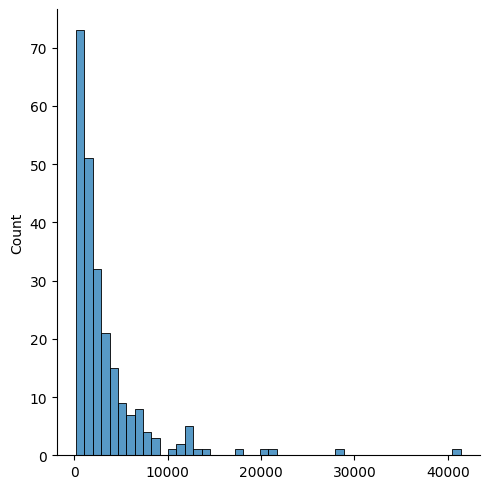

In [55]:
sns.displot(np.array(lengths))

In [21]:
import spacy
import spacy_stanza
import stanza
stanza.download("en")
# nlp = spacy_stanza.load_pipeline("en", processors="tokenize, pos, lemma, constituency, depparse, sentiment, ner")
nlp = spacy_stanza.load_pipeline("en", processors="tokenize, lemma")

2023-07-14 14:02:48 INFO: Downloading default packages for language: en (English) ...
2023-07-14 14:02:51 INFO: File exists: /Users/Foal/stanza_resources/en/default.zip
2023-07-14 14:02:56 INFO: Finished downloading models and saved to /Users/Foal/stanza_resources.
2023-07-14 14:02:56 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2023-07-14 14:02:57 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| lemma     | combined |

2023-07-14 14:02:57 WARNING: GPU requested, but is not available!
2023-07-14 14:02:57 INFO: Using device: cpu
2023-07-14 14:02:57 INFO: Loading: tokenize
2023-07-14 14:02:57 INFO: Loading: lemma
2023-07-14 14:02:57 INFO: Done loading processors!


In [11]:
docs = process_text.process_corpus(corpus, nlp)

Processing corpus with spaCy-pipeline


Documents: 100%|██████████| 11890/11890 [34:35<00:00,  5.73it/s]  


In [12]:
docs_join = [process_text.list_to_string(doc) for doc in docs]

In [ ]:
import dill as pickle
pickle.dump(docs_join, open('../output/pickled/docs_join.pkl', 'wb'))
docs_join = pickle.load(open('../output/pickled/docs_join.pkl', 'rb'))

In [5]:
topic_model, topics, probs = topic_extractor.bert_inspired(docs_join)

Batches:   0%|          | 0/372 [00:00<?, ?it/s]

2023-07-13 17:52:31,044 - BERTopic - Transformed documents to Embeddings
2023-07-13 17:53:00,540 - BERTopic - Reduced dimensionality
2023-07-13 17:53:03,796 - BERTopic - Clustered reduced embeddings


In [ ]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,6954,-1_demand_revenue_market_growth,"[demand, revenue, market, growth, company, ukr...",[q2 result update progress exit russia new cap...
1,0,840,0_humanitarian_crisis_ukraine_support,"[humanitarian, crisis, ukraine, support, organ...",[yes obviously good reason question day humani...
2,1,326,1_agricultural_fertilizer_wheat_farm,"[agricultural, fertilizer, wheat, farm, produc...",[sadden news image come war zone thought praye...
3,2,294,2_ukraine_ukrainian_humanitarian_refugee,"[ukraine, ukrainian, humanitarian, refugee, po...",[let directly start summary ambiguous quarter ...
4,3,280,3_business_market_opportunity_example,"[business, market, opportunity, example, envir...",[yes thanks great question think spenser menti...
...,...,...,...,...,...
66,65,11,65_inflation_forecast_economy_gdp,"[inflation, forecast, economy, gdp, market, ec...",[enter 2021 rate start little high second quar...
67,66,11,66_cobalt_nordion_supply_supplier,"[cobalt, nordion, supply, supplier, utility, r...",[thank scott transitioning q&a like address to...
68,67,10,67_pipeline_oil_demand_shale,"[pipeline, oil, demand, shale, gulf, gas, prod...",[strong financial result constructive outlook ...
69,68,10,68_geopolitical_crimea_ukraine_market,"[geopolitical, crimea, ukraine, market, tradin...",[want bit cautious uncertainty cause ukraine s...


In [14]:
# Calculate the topic distributions on a token-level
topic_distr, topic_token_distr = topic_model.approximate_distribution(docs_join, calculate_tokens=True)

  0%|          | 0/12 [00:00<?, ?it/s]

100%|██████████| 12/12 [00:53<00:00,  4.44s/it]


In [15]:
topic_model.visualize_distribution(topic_distr[1])

In [17]:
# Visualize the token-level distributions
df = topic_model.visualize_approximate_distribution(docs_join[1], topic_token_distr[1])
df

,let,directly,slide,page,overview,economy,country,forecast,read,previous,quarter,think,economy,poise,india,rebound,post,come,difficult,period,covid,lockdown,thing,like,admit,live,turbulent,time,inflationary,economy,result,solid,demand,come,post,covid,ukraine,war,commodity,time,high,severe,shortage,market,context,fact,government,world,try,rein,inflation,probably,little,bit,turbulence,ahead,hard,predict,crystal,ball,gaze,future,think,prepare,headwind,tailwind,clearly,able,predict,overall,macroeconomic,situation,head
0_humanitarian_crisis_ukraine_support,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.105,0.227,0.227,0.227,0.122,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1_agricultural_fertilizer_wheat_farm,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.106,0.230,0.357,0.357,0.250,0.126,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2_ukraine_ukrainian_humanitarian_refugee,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.115,0.115,0.115,0.115,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3_business_market_opportunity_example,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.140,0.140,0.140,0.140,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.148,0.148,0.148,0.148,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
6_logistics_shortage_production_demand,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.107,0.238,0.238,0.238,0.131,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.111,0.111,0.111,0.111,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
14_demand_production_supply_supplier,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.104,0.104,0.104,0.104,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.133,0.133,0.133,0.133,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
15_inflation_recession_gdp_economy,0.000,0.000,0.132,0.268,0.438,0.607,0.475,0.338,0.168,0.182,0.301,0.464,0.618,0.435,0.429,0.266,0.112,0.112,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.125,0.312,0.470,0.658,0.533,0.346,0.188,0.000,0.100,0.238,0.355,0.479,0.379,0.241,0.125,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.109,0.109,0.109,0.109,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
17_automotive_demand_shortage_truck,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000

In [7]:
topic_model.get_topic(0)

[('humanitarian', 0.430711),
 ('crisis', 0.39409357),
 ('ukraine', 0.36976126),
 ('support', 0.36530116),
 ('organization', 0.3563861),
 ('ukrainian', 0.33268934),
 ('refugee', 0.32814825),
 ('business', 0.32289648),
 ('war', 0.3121488),
 ('affect', 0.30873895)]

In [ ]:
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('paraphrase-distilroberta-base-v1')
sentence1 = "Now this slide talks more about the immediate impact where the combination of sanctions and also business destruction in Ukraine leads or may lead to supply chain disruptions."
sentence2 = "We obviously intensively evaluate all the potential impacts, created a task force that meets almost daily to follow on these topics and basically do preventive measures as to limit the potential impact on CEZ."

doc1 = nlp(sentence1)
doc2 = nlp(sentence2)
similarity = doc1.similarity(doc2)

sentences_ = [sentence1, sentence2]
sentence_embeddings = model.encode(sentences_)

print("Cosine Similarity: " + str(util.pytorch_cos_sim(sentence_embeddings[0], sentence_embeddings[1]).item()))
print("similiarity: " + str(similarity))

Cosine Similarity: 0.2044866681098938
similiarity: 0.0


In [10]:
# import dill as pickle
# pickle.dump(events_russia, open('../output/pickled/events_russia.pkl', 'wb'))
# pickle.dump(events, open('../output/pickled/events.pkl', 'wb'))

Create a DataFrame with the following columns and save it as a csv file:

In [7]:
df = pd.DataFrame({'file': file,
                   'year_upload': year_upload,
                   'company': company,
                   'ticker':ticker,
                   'ticker_new': ticker_new,
                   'date': dates,
                   'dates_num' : numeric_values,
                   'russia': russia_and_sanction,
                   'russia_count': russia_count,
                   'sanction_count': sanction_count,
                   'election': election})

In [6]:
docs = [event['presentation_collapsed'] + "\n" + event['qa_collapsed'] for event in events_russia]

In [6]:
df.to_csv('../output/data/overview.csv', index=False)

In [7]:
#  df[['company', 'ticker', 'ticker_new', 'date', 'russia', 'russia_count', 'sanction_count']].to_csv('../output/data/overview_jakob.csv', index=False)
# with open('../output/data/overview_jakob.csv', 'rb') as f_in:
#     with gzip.open('../output/data/overview_jakob.csv.gz', 'wb') as f_out:
#         shutil.copyfileobj(f_in, f_out)

Create 15 samples for each category: russia and election and save it in the
corresponding directory.

In [8]:
if len(df[df['russia'] == 'russia & sanctions']) >0:sample_files_russia = df[df['russia'] == 'russia'].sample(8)['file'].tolist() + df[df['russia'] == 'russia & sanctions'].sample(7)['file'].tolist()
if len(df[df['election'] == 'presidential election']) >0: sample_files_election = df[df['election'] == 'presidential election'].sample(15)['file'].tolist()

In [9]:
# delete all files in folder
if 'sample_files_russia' in locals() or 'sample_files_russia' in globals():
    folder = '../output/sample transcripts/russia/'
    files = os.listdir(folder)
    for f in files:
        os.remove(folder + f)
    # copy sample files to folder
    for file in sample_files_russia:
        shutil.copy(file, folder)

In [10]:
# delete all files in folder
if 'sample_files_election' in locals() or sample_files_election in globals():
    folder = '../output/sample transcripts/election/'
    files = os.listdir(folder)
    for f in files:
        os.remove(folder + f)
    # copy sample files to folder
    for file in sample_files_election:
        shutil.copy(file, folder)

## Figures

Count the number of occasions where the word "russia" (and "sanction") appears in the earnings call.

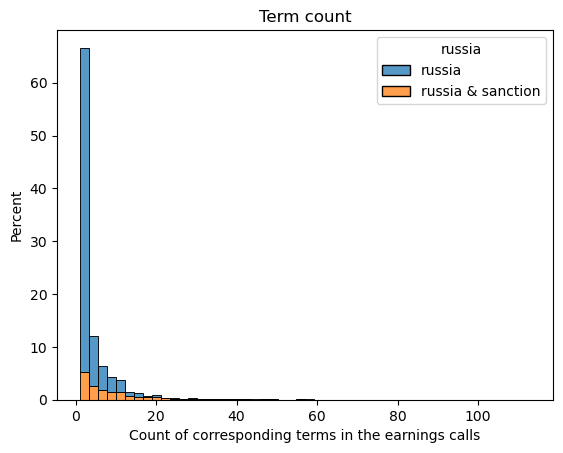

In [11]:
sns.histplot(df[df['russia_count']>=1], x='russia_count', hue="russia", bins=50, stat="percent", common_norm=True, multiple="stack")
plt.xlabel('Count of corresponding terms in the earnings calls')
plt.ylabel('Percent')
plt.title('Term count')
plt.show()

Average mentions of "russia" per earnings call.

In [12]:
np.array(russia_count).mean()

0.7839888358197221

Average mentions of "russia" per earnings call if "russia" is mentioned at
least once.

In [13]:
np.array([el for el in russia_count if el > 0]).mean()

4.389940567906669

Average mentions of "sanction" per earnings call.

In [14]:
np.array([event['body_orig'].lower().count('sanction') for event in events]).mean()

0.11202293006670876

Event distribution over time highlighting the different categories.

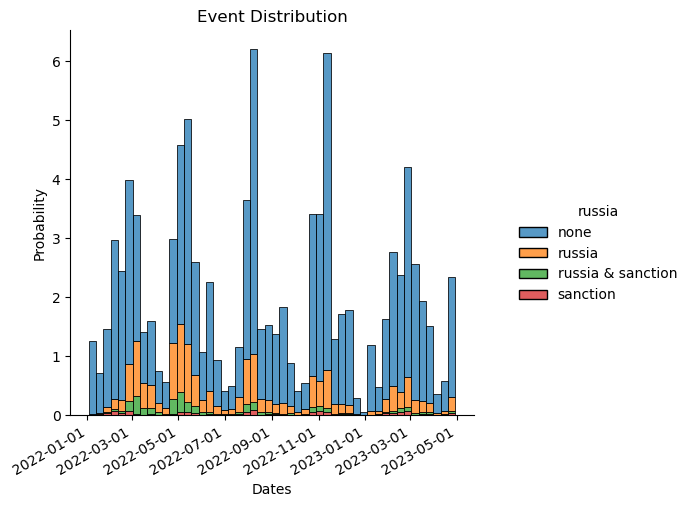

In [15]:
# plt.hist(numeric_values, bins=50)
# sns.histplot(numeric_values, bins=50)
sns.displot(df, x="dates_num", hue="russia", bins=50, stat="percent", common_norm=True, multiple="stack")
# plt.plot_date(dates, numeric_values, '-o')  # '-o' adds markers on the data points
plt.xlabel('Dates')
plt.ylabel('Probability')
plt.title('Event Distribution')

# Add x-axis ticks and labels
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Customize date format as needed

plt.gcf().autofmt_xdate()  # Adjusts the date labels rotation for better visibility

plt.show()

Event proportion over time highlighting the different categories.

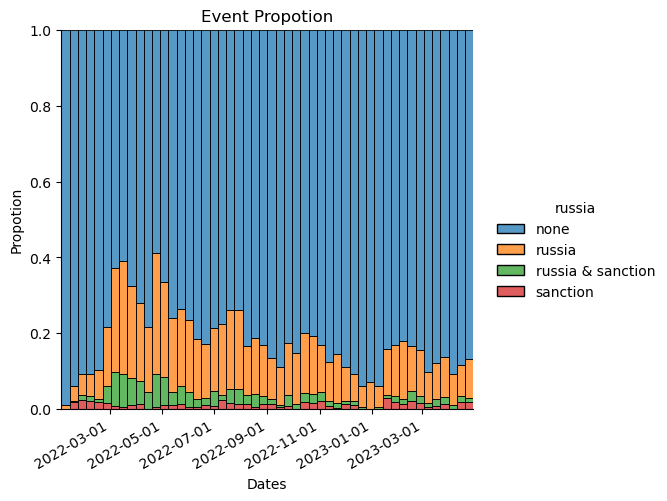

In [16]:
# plt.hist(numeric_values, bins=50)
# sns.histplot(numeric_values, bins=50)
sns.displot(df, x="dates_num", hue="russia", bins=50, stat="proportion", common_norm=True, multiple="fill")
# plt.plot_date(dates, numeric_values, '-o')  # '-o' adds markers on the data points
plt.xlabel('Dates')
plt.ylabel('Propotion')
plt.title('Event Propotion')

# Add x-axis ticks and labels
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Customize date format as needed

plt.gcf().autofmt_xdate()  # Adjusts the date labels rotation for better visibility

plt.show()

Polars

In [5]:
keys_to_keep = ['file', 'body_orig']

In [8]:
events_new_trimmed = [{key: event[key] for key in keys_to_keep} for event in events_new]

In [9]:
eventsDF = pl.from_dicts(events_new_trimmed)

In [28]:
eventsDF = eventsDF.with_columns(pl.col("body_orig").str.count_match('(E|e)lections').alias("elections_count"))
eventsDF = eventsDF.with_columns(pl.col("body_orig").str.count_match('(S|s)anctions').alias("sanctions_count"))
eventsDF = eventsDF.with_columns(pl.col("body_orig").str.count_match('(R|r)ussia').alias("russia_count"))

In [37]:
len(eventsDF.filter(pl.col("elections_count") > 0))

1535

In [36]:
len(eventsDF.filter((pl.col("sanctions_count") > 0) & (pl.col("russia_count") > 0)))

1533

In [7]:
file = "../data/Transcripts/2022/15232031_T.xml"

In [14]:
for _, elem in etree.iterparse(file):
            tag = elem.tag
            if tag is not None:
                text = elem.text
                if tag == "Body":
                    break

In [54]:
for event, elem in etree.iterparse(file):
    if elem is not None:
        print(elem.tag)

Headline
Body
EventStory
eventTitle
city
companyName
companyTicker
startDate
Event
